<a href="https://colab.research.google.com/github/MishraShardendu22/CNN-Deep-Learning-Project-Implementation/blob/main/CNN_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
!pip install tensorflow

In [23]:
import tensorflow as tf
import os
from google.colab import drive


if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print('Google Drive is already mounted.')

path = '/content/drive/MyDrive/DisasterModel'

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

print(f"Using dataset path: {path}")
print(f"Using image size: {IMG_SIZE}")
print(f"Using batch size: {BATCH_SIZE}")

Google Drive is already mounted.
Using dataset path: /content/drive/MyDrive/DisasterModel
Using image size: (128, 128)
Using batch size: 32


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Instantiate EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Instantiate ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=0.00001
)

print("EarlyStopping and ReduceLROnPlateau callbacks created.")

EarlyStopping and ReduceLROnPlateau callbacks created.


In [25]:
from tensorflow.keras.utils import image_dataset_from_directory

# Define the paths for the training and validation data subdirectories
train_data_path = os.path.join(path, 'train')
val_data_path = os.path.join(path, 'validation')

print(f"Training data path: {train_data_path}")
print(f"Validation data path: {val_data_path}")

# Re-create train_ds pointing to the 'train' subdirectory
train_ds = image_dataset_from_directory(
    train_data_path,
    labels='inferred',
    label_mode='int',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Re-create val_ds pointing to the 'validation' subdirectory
val_ds = image_dataset_from_directory(
    val_data_path,
    labels='inferred',
    label_mode='int',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Datasets reloaded from specific 'train' and 'validation' subdirectories.")

# Get class names from the actual training data path directories
class_names = sorted(os.listdir(train_data_path))
print(f"New class names: {class_names}")

# Reapply normalization layer
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
print("Normalization re-applied to both datasets.")

# Reapply data augmentation layers to the new train_ds
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
print("Data augmentation layers re-applied to train_ds.")

Training data path: /content/drive/MyDrive/DisasterModel/train
Validation data path: /content/drive/MyDrive/DisasterModel/validation
Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Datasets reloaded from specific 'train' and 'validation' subdirectories.
New class names: ['cyclone', 'earthquake', 'flood', 'wildfire']
Normalization re-applied to both datasets.
Data augmentation layers re-applied to train_ds.


Reconfigured Training dataset class distribution:
  cyclone: 400
  earthquake: 400
  flood: 400
  wildfire: 400

Reconfigured Validation dataset class distribution:
  cyclone: 100
  earthquake: 100
  flood: 100
  wildfire: 100


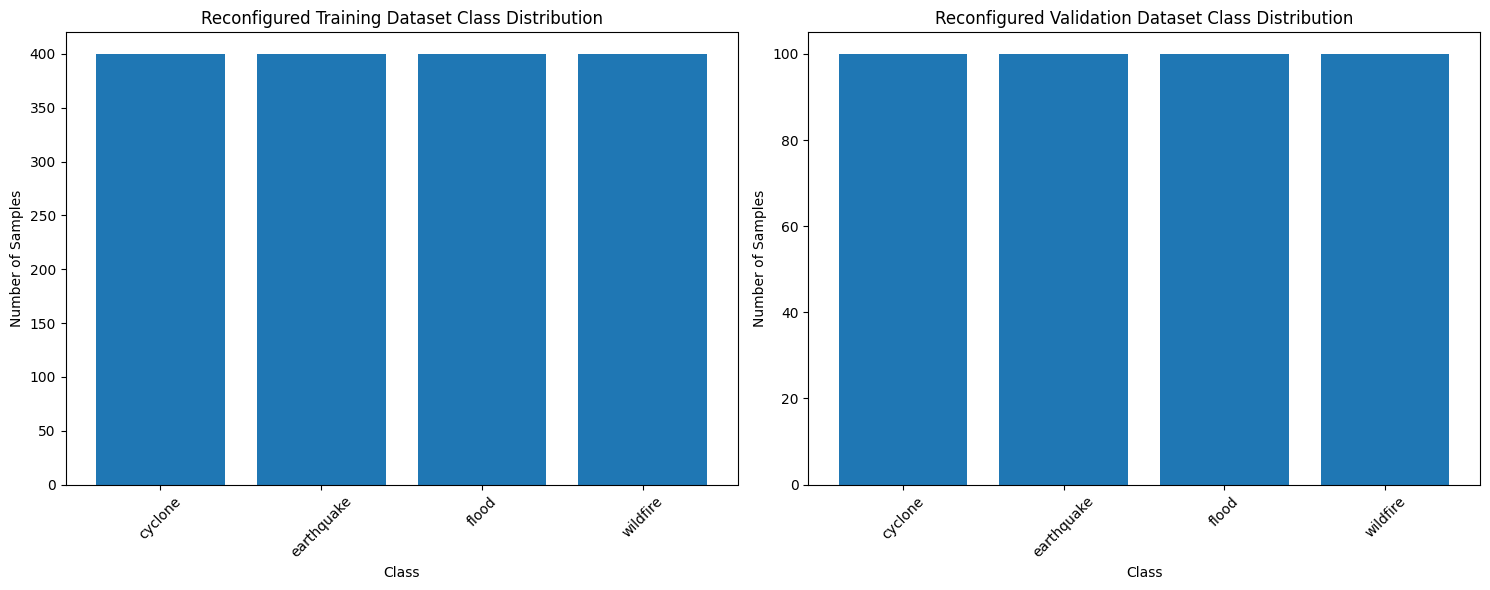

Class distribution plots generated for reconfigured training and validation datasets.


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Extract labels from the reconfigured train_ds
new_train_labels = []
for _, labels in train_ds.unbatch():
    new_train_labels.append(labels.numpy())
new_train_labels = np.array(new_train_labels)

# Extract labels from the reconfigured val_ds
new_val_labels = []
for _, labels in val_ds.unbatch():
    new_val_labels.append(labels.numpy())
new_val_labels = np.array(new_val_labels)

# Count occurrences for new_train_ds and print
new_train_distribution = np.bincount(new_train_labels)
print("Reconfigured Training dataset class distribution:")
for i, count in enumerate(new_train_distribution):
    print(f"  {class_names[i]}: {count}")

# Count occurrences for new_val_ds and print
new_val_distribution = np.bincount(new_val_labels)
print("\nReconfigured Validation dataset class distribution:")
for i, count in enumerate(new_val_distribution):
    print(f"  {class_names[i]}: {count}")

# Create subplots for training and validation distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot training dataset class distribution
axes[0].bar(class_names, new_train_distribution)
axes[0].set_title('Reconfigured Training Dataset Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Plot validation dataset class distribution
axes[1].bar(class_names, new_val_distribution)
axes[1].set_title('Reconfigured Validation Dataset Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Class distribution plots generated for reconfigured training and validation datasets.")

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax') # Output layer with number of classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_augmented = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)
print("Model recompiled and retraining initiated with data augmentation and callbacks.")

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.3611 - loss: 1.3261 - val_accuracy: 0.6325 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - accuracy: 0.7236 - loss: 0.7716 - val_accuracy: 0.7375 - val_loss: 0.8726 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 482ms/step - accuracy: 0.7643 - loss: 0.6166 - val_accuracy: 0.7000 - val_loss: 1.0423 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - accuracy: 0.7745 - loss: 0.6133 - val_accuracy: 0.8075 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 504ms/step - accuracy: 0.8306 - loss: 0.4655 - val_accuracy: 0.8325 - val_loss: 0.4885 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 504ms/step - accuracy: 0.8286 - loss: 0.4561 - val_accuracy: 0.8000 - val_loss: 0.6102 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 488ms/step - accuracy: 0.8384 - loss: 0.

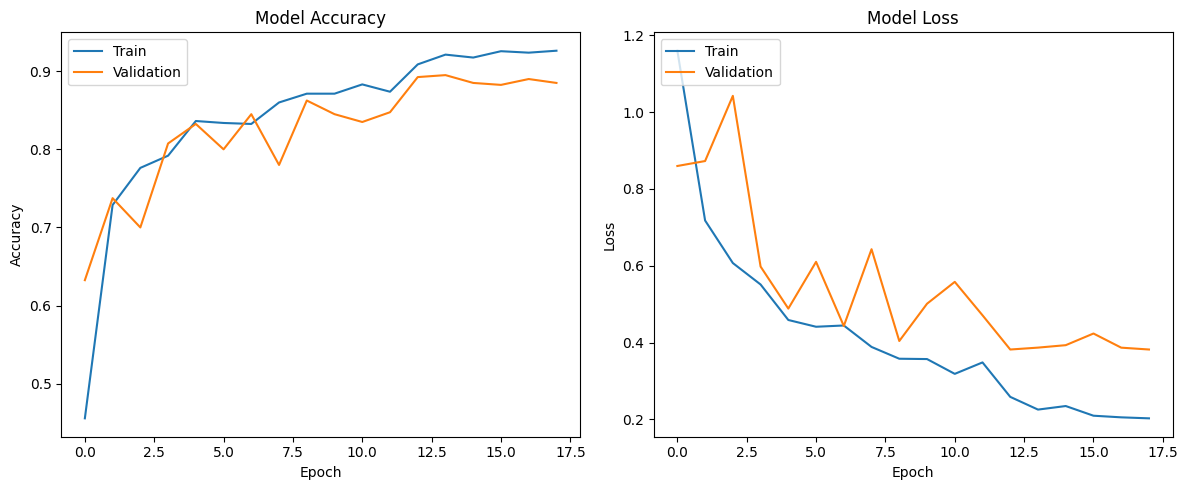

Training history plots generated.


In [28]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

print("Training history plots generated.")

## Predict with a new image

To predict with a new image, you'll need to upload it and then preprocess it to match the input requirements of the model. The model expects images of `IMG_SIZE` (128x128) and in RGB format, normalized to a 0-1 range.

Saving ai-generated-a-violent-earthquake-cracks-open-the-ground-splitting-roads-and-toppling-buildings-free-photo.webp to ai-generated-a-violent-earthquake-cracks-open-the-ground-splitting-roads-and-toppling-buildings-free-photo (1).webp


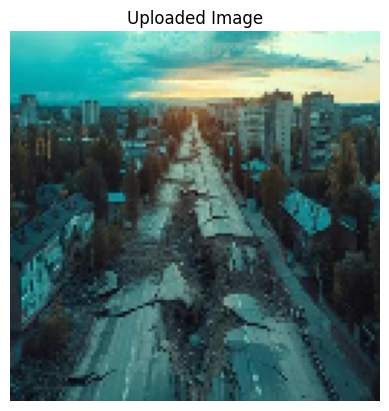

Image loaded from /content/ai-generated-a-violent-earthquake-cracks-open-the-ground-splitting-roads-and-toppling-buildings-free-photo (1).webp
Image array shape: (1, 128, 128, 3)


In [31]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Upload the image
uploaded = files.upload()

# Get the filename of the uploaded image
for fn in uploaded.keys():
  img_path = '/content/' + fn

# Load and preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Create a batch
img_array = img_array / 255.0  # Normalize the image

# Display the uploaded image
plt.imshow(img)
plt.title("Uploaded Image")
plt.axis('off')
plt.show()

print(f"Image loaded from {img_path}")
print(f"Image array shape: {img_array.shape}")

In [32]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the predicted class and confidence
predicted_class_index = np.argmax(score)
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(score) * 100

print(f"This image most likely belongs to {predicted_class_name} with a {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
This image most likely belongs to earthquake with a 32.66% confidence.
